In [1]:
%%capture
!pip install langgraph
!pip install langchain_openai
!pip install langchain_core
!pip install pygraphviz


In [2]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz --no-binary=pygraphviz --force-reinstall


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [3]:
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image
from pprint import pprint
from google.colab import userdata



In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7, api_key=userdata.get('OPENAI_API_KEY'))

In [6]:
class State(TypedDict):
    text: str
    french: str
    spanish: str
    japanese: str
    combined_output: str

In [7]:
def translate_french(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to French:\n\n{state['text']}")
    return {"french": response.content.strip()}

In [8]:
def translate_spanish(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Spanish:\n\n{state['text']}")
    return {"spanish": response.content.strip()}

In [9]:
def translate_japanese(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Japanese:\n\n{state['text']}")
    return {"japanese": response.content.strip()}

In [10]:
def aggregator(state: State) -> dict:
    combined = f"Original Text: {state['text']}\n\n"
    combined += f"French: {state['french']}\n\n"
    combined += f"Spanish: {state['spanish']}\n\n"
    combined += f"Japanese: {state['japanese']}\n"
    return {"combined_output": combined}

In [11]:
graph = StateGraph(State)

In [12]:
graph.add_node("translate_french", translate_french)
graph.add_node("translate_spanish", translate_spanish)
graph.add_node("translate_japanese", translate_japanese)
graph.add_node("aggregator", aggregator)

In [13]:
# Connect parallel nodes from START
graph.add_edge(START, "translate_french")
graph.add_edge(START, "translate_spanish")
graph.add_edge(START, "translate_japanese")

In [14]:
# Connect all translation nodes to the aggregator
graph.add_edge("translate_french", "aggregator")
graph.add_edge("translate_spanish", "aggregator")
graph.add_edge("translate_japanese", "aggregator")

In [15]:
# Final node
graph.add_edge("aggregator", END)

In [16]:
# Compile the graph
app = graph.compile()

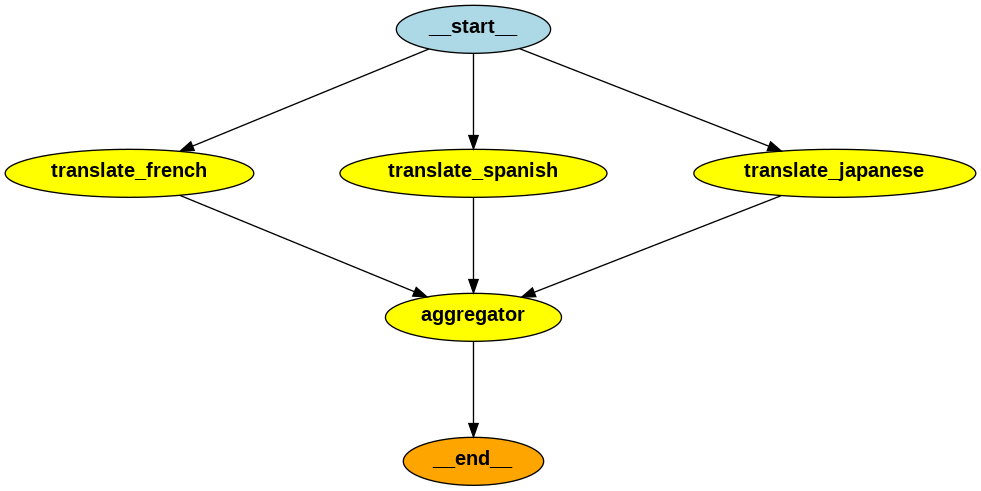

In [17]:
display(Image(app.get_graph().draw_png()))

In [18]:
input_text = {
        "text": "Good morning! I hope you have a wonderful day."
}

result = app.invoke(input_text)

In [19]:
result

{'text': 'Good morning! I hope you have a wonderful day.',
 'french': "Bonjour ! J'espère que vous passerez une merveilleuse journée.",
 'spanish': '¡Buenos días! Espero que tengas un día maravilloso.',
 'japanese': 'おはようございます！素晴らしい一日になりますように。',
 'combined_output': "Original Text: Good morning! I hope you have a wonderful day.\n\nFrench: Bonjour ! J'espère que vous passerez une merveilleuse journée.\n\nSpanish: ¡Buenos días! Espero que tengas un día maravilloso.\n\nJapanese: おはようございます！素晴らしい一日になりますように。\n"}